In [1]:
# useful additional packages
import matplotlib.pyplot as plt
import numpy as np
from qiskit.circuit.library import zz_feature_map
from sklearn.datasets import make_classification
from sklearn.metrics import classification_report, log_loss
from sklearn.preprocessing import StandardScaler
# import svc
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split

# Load dataset

In [2]:
n_features = 4
n_classes = 2
n_informative_features = 2
n_redundant = n_features - n_informative_features
n_clusters_per_class = 1
X, y = make_classification(n_samples=500,
                           n_classes = n_classes,
                           n_features=n_features,
                           n_informative=n_informative_features,
                           n_redundant=n_redundant,
                           n_clusters_per_class=n_clusters_per_class,
                           random_state=42, shuffle=True)
print(X.shape)
print(y.shape)



(500, 4)
(500,)


In [3]:
# Use standard scaler to normalize the data
scaler = StandardScaler()
X = scaler.fit_transform(X)

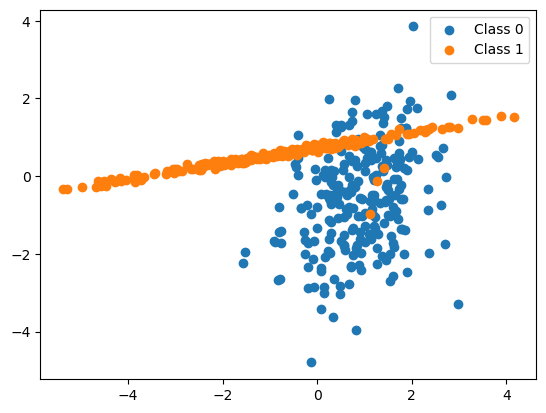

In [4]:
# Plot the data using PCA
from sklearn.decomposition import PCA
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X)
for c in np.unique(y):
    plt.scatter(X_pca[y==c, 0], X_pca[y==c, 1], label=f'Class {c}')
plt.legend()
plt.show()

In [5]:
# Train test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Create circuit

In [6]:
n_qubits = X.shape[1]
print(f"Number of qubits: {n_qubits}")


Number of qubits: 4


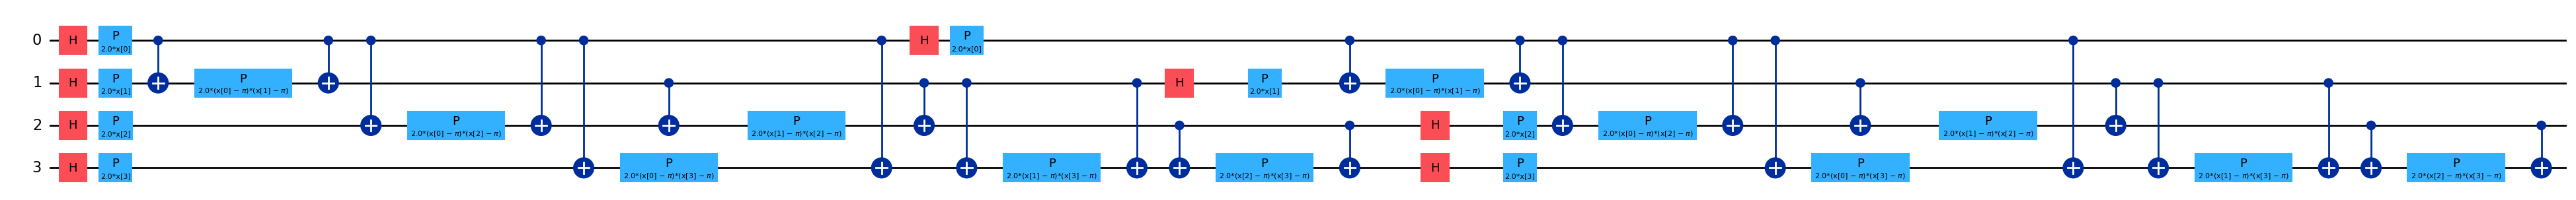

In [7]:
# Create the encoding circuit
enc_qc = zz_feature_map(n_qubits,parameter_prefix='x')

enc_qc.draw('mpl', fold=-1)

# Create kernel

In [8]:
from qiskit_ibm_runtime import Estimator
from qiskit_aer import AerSimulator
from qiskit.quantum_info import Statevector, SparsePauliOp

def run_estimator(pubs, shots):
    backend = AerSimulator()
    estimator = Estimator(mode=backend, options={'default_shots': shots})

    job = estimator.run(pubs)
    return job.result()

def define_0s_fidelity_operator(n_qubits):
    """
    Define the fidelity operator based on the target state.

    Args:
        n_qubits (int): The number of qubits.

    Returns:
        SparsePauliOp: The fidelity operator.
    """
    statevector = Statevector.from_label('0' * n_qubits)
    operator = statevector.to_operator()
    # Convert the operator to a SparsePauliOp
    return SparsePauliOp.from_operator(operator)

In [9]:
# Kernel is ComputeUncompute
def kernel(X1, X2):
    """Compute the kernel between two sets of data points."""
    # Create 2 copies of the encoding circuit
    enc_qc1 = enc_qc.copy()
    enc_qc2 = enc_qc.copy()
    # Bind the parameters of the encoding circuit to the data points
    assigned_enc_1 = enc_qc1.assign_parameters(X1, inplace=False)
    assigned_enc_2 = enc_qc2.assign_parameters(X2, inplace=False)
    # Make dagger of the second circuit
    assigned_enc_2 = assigned_enc_2.inverse()
    # Create a quantum circuit that applies the encoding circuit to the data points
    qc = assigned_enc_1.compose(assigned_enc_2, inplace=False)
    # Define the fidelity operator
    fidelity_operator = define_0s_fidelity_operator(n_qubits)
    pubs = [(qc, fidelity_operator)]
    # Run the estimator to get the fidelity
    shots = 1024
    result = run_estimator(pubs, shots)
    fidelity = result[0].data.evs.tolist()
    return fidelity


In [10]:
import tqdm
# Compute the kernel matrix
def compute_kernel_matrix(X):
    """Compute the kernel matrix for a set of data points."""
    n_samples = X.shape[0]
    K = np.zeros((n_samples, n_samples))
    progress_bar = tqdm.tqdm(total=n_samples * n_samples, desc="Computing kernel matrix")
    for i in range(n_samples):
        for j in range(n_samples):
            K[i, j] = kernel(X[i], X[j])
            progress_bar.update(1)
    progress_bar.close()
    return K

def compute_test_kernel_matrix(X_train, X_test):
    """Compute the kernel matrix for a set of data points."""
    n_samples = X_test.shape[0]
    K = np.zeros((n_samples, X_train.shape[0]))
    progress_bar = tqdm.tqdm(total=n_samples * X_train.shape[0], desc="Computing kernel matrix")
    for i in range(n_samples):
        for j in range(X_train.shape[0]):
            K[i, j] = kernel(X_test[i], X_train[j])
            progress_bar.update(1)
    progress_bar.close()
    return K

In [11]:
def create_kernel_pub(X1, X2):
    """Create the kernel public key."""
    # Create 2 copies of the encoding circuit
    enc_qc1 = enc_qc.copy()
    enc_qc2 = enc_qc.copy()
    # Bind the parameters of the encoding circuit to the data points
    assigned_enc_1 = enc_qc1.assign_parameters(X1, inplace=False)
    assigned_enc_2 = enc_qc2.assign_parameters(X2, inplace=False)
    # Make dagger of the second circuit
    assigned_enc_2 = assigned_enc_2.inverse()
    # Create a quantum circuit that applies the encoding circuit to the data points
    qc = assigned_enc_1.compose(assigned_enc_2, inplace=False)
    # Define the fidelity operator
    fidelity_operator = define_0s_fidelity_operator(n_qubits)
    pub = (qc, fidelity_operator)
    return pub
def compute_kernel_matrix_batch(X):
    """Compute the kernel matrix for a set of data points."""
    n_samples = X.shape[0]
    K = np.zeros((n_samples, n_samples))
    pubs = []
    for i in range(n_samples):
        for j in range(n_samples):
            pub = create_kernel_pub(X[i], X[j])
            pubs.append(pub)
    # Run the estimator
    shots = 1024
    results = run_estimator(pubs, shots)
    for i in range(n_samples):
        for j in range(n_samples):
            K[i, j] = results[i * n_samples + j].data.evs.tolist()
    return K
def compute_test_kernel_matrix_batch(X_train, X_test):
    """Compute the kernel matrix for a set of data points."""
    n_samples = X_test.shape[0]
    K = np.zeros((n_samples, X_train.shape[0]))
    pubs = []
    for i in range(n_samples):
        for j in range(X_train.shape[0]):
            pub = create_kernel_pub(X_test[i], X_train[j])
            pubs.append(pub)
    # Run the estimator
    shots = 1024
    results = run_estimator(pubs, shots)
    for i in range(n_samples):
        for j in range(X_train.shape[0]):
            K[i, j] = results[i * X_train.shape[0] + j].data.evs.tolist()
    return K

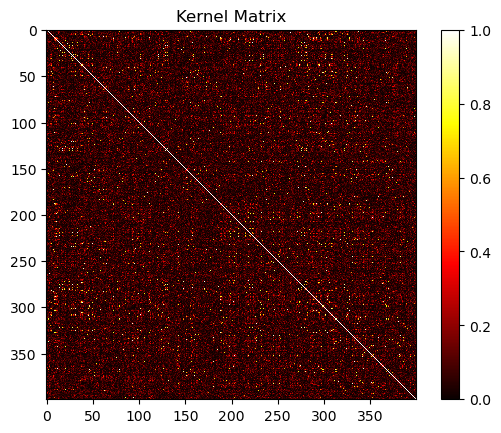

In [12]:
kernel_matrix = compute_kernel_matrix_batch(X_train)
# Plot the kernel matrix
plt.imshow(kernel_matrix, cmap='hot', interpolation='nearest')
plt.colorbar()
plt.title('Kernel Matrix')
plt.show()

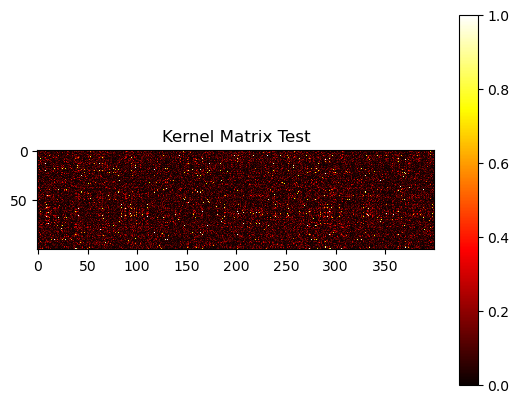

In [13]:
# Create SVC model with the kernel matrix
svc = SVC(kernel='precomputed')
# Train the SVC model
svc.fit(kernel_matrix, y_train)
# Predict the labels of the test set
kernel_matrix_test = compute_test_kernel_matrix_batch(X_train, X_test)
# Plot the kernel matrix
plt.imshow(kernel_matrix_test, cmap='hot', interpolation='nearest')
plt.colorbar()
plt.title('Kernel Matrix Test')
plt.show()


In [14]:
y_pred = svc.predict(kernel_matrix_test)
# classification report
clas_rep = classification_report(y_test, y_pred, output_dict=True)
print(classification_report(y_test, y_pred, target_names=[f'Class {i}' for i in range(n_classes)]))

              precision    recall  f1-score   support

     Class 0       0.87      0.85      0.86        46
     Class 1       0.87      0.89      0.88        54

    accuracy                           0.87       100
   macro avg       0.87      0.87      0.87       100
weighted avg       0.87      0.87      0.87       100



In [15]:
svc.n_support_

array([113,  98], dtype=int32)